In [32]:
%matplotlib inline
import matplotlib.pyplot as plt


In [33]:
# %load test_utils.py
import os
import json

TEST_METHOD_DEF_FILE = 'testcase_method.json'

def readTestMethod():
    data = json.load(open(TEST_METHOD_DEF_FILE))
    if 'testMethods' not in data:
        print('testMethods is not defined in json')
        exit(1)
    testMethods = data['testMethods']
    num_of_test_methods = len(testMethods)
    return (testMethods, num_of_test_methods)

def getTestMethod(index):
    testMethods, num_of_test_methods = readTestMethod()
    
    return testMethods[index]

In [34]:
# %load AITestcase.py
# Author: Chong Lin
# Date: 2017-11

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

# Define training samples
#TESTCASE_TRAINING = os.path.join(os.path.dirname(__file__), "training_features.npy")
TESTCASE_TRAINING = "training_features.npy"
MODEL_PARAMETERS = 'model_parameters.npy'

def train_LR_model(learning_rate=0.5):  

  # Load training examples
  data = np.load(TESTCASE_TRAINING)
  features = data.item().get('features')
  labels = data.item().get('labels')

  num_of_labels = labels.shape[1]
  num_of_training_sample = labels.shape[0]
  num_of_features = features.shape[1]
  print('number of test methods: ' + str(num_of_labels))
  print('number of training samples: ' + str(num_of_training_sample))
  print('number of features: ' + str(num_of_features))


  # Build training dataset
  labels_placeholder = tf.placeholder(labels.dtype, labels.shape)
  features_placeholder = tf.placeholder(features.dtype, features.shape)
  
  dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
  batched_dataset = dataset.batch(2).repeat()    # repeat to fetch element in dataset
  iterator = batched_dataset.make_initializable_iterator()

  X = tf.placeholder(tf.float32, [None, num_of_features])
  W = tf.get_variable('weigth', dtype=tf.float32, initializer=tf.random_uniform([num_of_features, num_of_labels], maxval=2))
  b = tf.get_variable('bais', dtype=tf.float32, initializer=tf.random_uniform([num_of_labels], maxval=2)) #tf.Variable([5], dtype=tf.float32)
  y = tf.matmul(X, W) + b
  y_ = tf.placeholder(tf.float32, [None, num_of_labels])

  # Define loss function
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
  train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
  
  with tf.Session() as sess:
      tf.global_variables_initializer().run()
      # Retrieve a single traning sample:
      sess.run(iterator.initializer, feed_dict={features_placeholder: features, labels_placeholder: labels})

      costs = []
      # Train
      for i in range(500): 
          next_element = iterator.get_next()
          batch_xs, batch_ys = sess.run(next_element)   
          cost, t_step = sess.run([cross_entropy, train_step], feed_dict={X: batch_xs, y_: batch_ys})
          if i%50==0:
            print('training ' + str(i) + ' times, cost is: ' + str(cost))  
            costs.append(cost)

      # Test trained model
      correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
      print('training accuracy: ' + str(sess.run(accuracy, feed_dict={X: features,
                                          y_: labels})))

      print('Saving parameters to ' + MODEL_PARAMETERS)
      np.save(MODEL_PARAMETERS, {"W": W.eval(), "b": b.eval()})

    
  return costs

In [35]:
costs = []
with tf.variable_scope(name_or_scope='', reuse=tf.AUTO_REUSE):
     costs = train_LR_model(0.5)   

number of test methods: 5
number of training samples: 10
number of features: 11
training 0 times, cost is: 0.904312
training 50 times, cost is: 0.0539745
training 100 times, cost is: 0.0262912
training 150 times, cost is: 0.0175304
training 200 times, cost is: 0.013205
training 250 times, cost is: 0.0106178
training 300 times, cost is: 0.00889245
training 350 times, cost is: 0.00765799
training 400 times, cost is: 0.00672989
training 450 times, cost is: 0.00600622
training accuracy: 1.0
Saving parameters to model_parameters.npy


[0.90431231, 0.053974494, 0.026291151, 0.017530367, 0.013205043, 0.010617824, 0.0088924533, 0.0076579889, 0.0067298934, 0.0060062166]


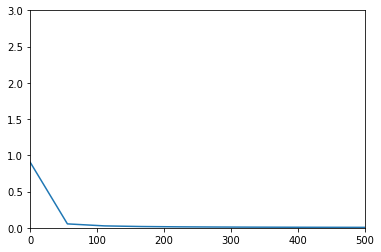

In [36]:
print(costs)
plt.xlim([0, 500])
plt.ylim([0, 3])
plt.plot(np.linspace(0, 500, num=len(costs)), costs)
plt.show()

In [37]:
def predict(samples, W, b):
    y = tf.matmul(samples, W) + b
    indexs = tf.argmax(y, axis=1)
    with tf.Session() as sess:
        return sess.run(indexs)
    

In [38]:
def loadModelParameters():
    params = np.load(MODEL_PARAMETERS).item()
    W = tf.constant(params.get('W'))
    b = tf.constant(params.get('b'))
    return (W, b)

In [39]:
def loadTestSample():
     # Load testing examples
    testdata = np.load('testing_features.npy').item().get('features')
    return tf.constant(testdata, dtype=tf.float32)

In [31]:
testdata = loadTestSample()
W, b = loadModelParameters() 
indexs = predict(testdata, W, b)
for i in range(0, len(indexs)):
    print('test step#' + str(i) + ": " + getTestMethod(indexs[i]))

test step#0: ingestTitle
test step#1: enableRuleset
test step#2: ingestTitle
